# Yelp Business Reviews - Sentiment Analysis

## Importing Libraries (will be edited)

In [1]:
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import findspark
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import IDF, StopWordsRemover, Tokenizer, VectorAssembler
from pyspark.ml.linalg import Vector
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, length, lit, lower, regexp_replace, size, split, filter, udf
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.functions import when

## Creating Spark Session

In [2]:
# Create a spark session
findspark.init()
spark = SparkSession.builder \
    .appName("Yelp_Sentiment_Analysis") \
    .master("local[8]") \
    .config("spark.executor.memory", "10g") \
    .config("spark.executor.cores", "3") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

### Patlarsa dene
#.config("spark.memory.offHeap.enabled","true") 
#.config("spark.memory.offHeap.size","10g")

In [44]:
# Get config
conf = spark.sparkContext.getConf()

# Print the configuration settings
print("spark.app.name = ", conf.get("spark.app.name"))
print("spark.master = ", conf.get("spark.master"))
print("spark.executor.memory = ", conf.get("spark.executor.memory"))
print("spark.executor.cores = ", conf.get("spark.executor.cores")),
print("spark.driver.memory = ", conf.get("spark.driver.memory"))

spark.app.name =  Yelp_Sentiment_Analysis
spark.master =  local[8]
spark.executor.memory =  10g
spark.executor.cores =  3
spark.driver.memory =  2g


## Preprocessing of Business Dataset

In [3]:
# Import business data
path_business = "../yelp_academic_dataset_business.json"
business = spark.read.json(path_business)

In [4]:
# Print first 10 rows
business.show(n=10, truncate=14)

+--------------+--------------+--------------+--------------+--------------+--------------+-------+----------+------------+--------------+-----------+------------+-----+-----+
|       address|    attributes|   business_id|    categories|          city|         hours|is_open|  latitude|   longitude|          name|postal_code|review_count|stars|state|
+--------------+--------------+--------------+--------------+--------------+--------------+-------+----------+------------+--------------+-----------+------------+-----+-----+
|1616 Chapal...|{NULL, NULL...|Pns2l4eNsfO...|Doctors, Tr...| Santa Barbara|          NULL|      0|34.4266787|-119.7111968|Abby Rappop...|      93101|           7|  5.0|   CA|
|87 Grasso P...|{NULL, NULL...|mpf3x-BjTdT...|Shipping Ce...|        Affton|{8:0-18:30,...|      1| 38.551126|  -90.335695| The UPS Store|      63123|          15|  3.0|   MO|
|5255 E Broa...|{NULL, NULL...|tUFrWirKiKi...|Department ...|        Tucson|{8:0-23:0, ...|      0| 32.223236| -110.8804

In [5]:
# Drop irrelevant columns
business = business.drop("hours").drop("attributes")

In [6]:
# Print current dataset schema
business.printSchema()

root
 |-- address: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- city: string (nullable = true)
 |-- is_open: long (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- stars: double (nullable = true)
 |-- state: string (nullable = true)



In [7]:
# Filter out rows with null 'categories'
business = business.filter(col("categories").isNotNull())

In [8]:
# Filter for businesses in US states
states = [
    "AL",
    "AK",
    "AZ",
    "AR",
    "CA",
    "CO",
    "CT",
    "DC",
    "DE",
    "FL",
    "GA",
    "HI",
    "ID",
    "IL",
    "IN",
    "IA",
    "KS",
    "KY",
    "LA",
    "ME",
    "MD",
    "MA",
    "MI",
    "MN",
    "MS",
    "MO",
    "MT",
    "NE",
    "NV",
    "NH",
    "NJ",
    "NM",
    "NY",
    "NC",
    "ND",
    "OH",
    "OK",
    "OR",
    "PA",
    "RI",
    "SC",
    "SD",
    "TN",
    "TX",
    "UT",
    "VT",
    "VA",
    "WA",
    "WV",
    "WI",
    "WY",
]

usa = business.filter(col("state").isin(states))

In [9]:
# Print out the total number of businesses in dataset
print(f"Number of US businesses in the dataset: {usa.count()}")

Number of US businesses in the dataset: 144669


In [10]:
# Filter restaurants and print out the total number
us_restaurants = usa.filter(usa["categories"].contains("Restaurants"))
print(f"Number of total US restaurants in the dataset: {us_restaurants.count()}")

Number of total US restaurants in the dataset: 49857


In [11]:
# Label every row with their respective type of cuisine
us_restaurants = us_restaurants.withColumn(
    "category",
    when(col("categories").contains("Korean"), "Korean")
    .when(col("categories").contains("Japanese"), "Japanese")
    .when(col("categories").contains("Chinese"), "Chinese")
    .when(col("categories").contains("Vietnamese"), "Vietnamese")
    .when(col("categories").contains("Thai"), "Thai")
    .when(col("categories").contains("Italian"), "Italian")
    .when(col("categories").contains("French"), "French")
    .when(col("categories").contains("American"), "American")
    .when(col("categories").contains("Mexican"), "Mexican")
    .when(col("categories").contains("Mediterranean"), "Mediterranean")
    .when(col("categories").contains("Greek"), "Greek")
    .when(col("categories").contains("Indian"), "Indian")
    .when(col("categories").contains("Hawaiian"), "Hawaiian")
    .when(col("categories").contains("African"), "African")
    .when(col("categories").contains("Spanish"), "Spanish")
    .when(col("categories").contains("Middle_eastern"), "Middle_eastern"),
)

In [12]:
# Drop the old category column and filter out null categories
us_restaurants = us_restaurants.drop("categories")
us_restaurants = us_restaurants.filter(col("category").isNotNull())

In [13]:
# Print out the number of restaurants that are labeled by their cuisine types
print(f"Number of labeled US restaurants in the dataset: {us_restaurants.count()}")

Number of labeled US restaurants in the dataset: 28450


In [14]:
# Check if the dataset contains any duplicated businesses
us_restaurants.groupBy("business_id").count().filter(col("count") > 1).count()

0

## Preprocessing of Review Dataset

In [15]:
# Import review data
path_review = "../yelp_academic_dataset_review.json"
review = spark.read.json(path_review)

In [16]:
# Print first 10 rows
review.show(n=10, truncate=20)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [17]:
# Print current dataset schema
review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [18]:
#Duplike kontrolü ekle

In [19]:
# Print out the total number of instances in 'reviews' dataset
print(f"Total number of reviews in the dataset : {review.count()}")

Total number of reviews in the dataset : 6990280


## Merging Business and Review Datasets

In [20]:
# Change the names of 'stars' columns in both datasets to avoid confusion
us_restaurants = us_restaurants.withColumnRenamed("stars", "avg_star")
review = review.withColumnRenamed("stars", "review_star")

In [21]:
# Merge the dataframes on 'business_id'
restaurants_reviews = us_restaurants.join(review, on="business_id", how="inner")

In [22]:
# Print the schema of merged dataframe
restaurants_reviews.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- address: string (nullable = true)
 |-- city: string (nullable = true)
 |-- is_open: long (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- avg_star: double (nullable = true)
 |-- state: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- review_star: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



## Preprocessing of Restaurants_Reviews Dataset

In [23]:
# Show the unique values of 'review_star'
#restaurants_reviews.select("review_star").distinct().show()

In [24]:
# Create a 'labels' column
# 4-5 Stars --> Positive
# 3 Stars --> Neutral
# 1-2 Stars --> Negative
restaurants_reviews = restaurants_reviews.withColumn(
    "labels",
    when(restaurants_reviews["review_star"] >= 4, "positive")
    .when(restaurants_reviews["review_star"] == 3, "neutral")
    .when(restaurants_reviews["review_star"] < 3, "negative"),
)

In [25]:
# Filter out neutral reviews and count the rest
restaurants_reviews = restaurants_reviews.where(
    restaurants_reviews["labels"] != "neutral"
)
# print(f'The number of positive and negative reviews : {restaurants_reviews.count()}')

## Data Transformation on Reviews

In [26]:
# Show 'text' column before transformation
restaurants_reviews.select("text").show(10, truncate=80)

+--------------------------------------------------------------------------------+
|                                                                            text|
+--------------------------------------------------------------------------------+
|Wow!  Yummy, different,  delicious.   Our favorite is the lamb curry and korm...|
|Cute interior and owner (?) gave us tour of upcoming patio/rooftop area which...|
|I am a long term frequent customer of this establishment. I just went in to o...|
|Amazingly amazing wings and homemade bleu cheese. Had the ribeye: tender, per...|
|Locals recommended Milktooth, and it's an amazing jewel of Indianapolis. I'm ...|
|Love going here for happy hour or dinner!  Great patio with fans to beat the ...|
|Good food--loved the gnocchi with marinara\nthe baked eggplant appetizer was ...|
|The bun makes the Sonoran Dog. It's like a snuggie for the pup. A first, it s...|
|Great place for breakfast! I had the waffle, which was fluffy and perfect, an...|
|The

In [27]:
# Convert 'text' to lowercase
restaurants_reviews = restaurants_reviews.withColumn("text", F.lower(F.col("text")))

In [28]:
# Transform review text by using regular expressions

# Replace all non-alphanumeric characters with a whitespace.
restaurants_reviews = restaurants_reviews.withColumn(
    "text_clean", F.regexp_replace(F.col("text"), "[^a-zA-Z0-9\s]", " ")
)

# Replace all line break character with a whitespace.
restaurants_reviews = restaurants_reviews.withColumn(
    "text_clean", F.regexp_replace(F.col("text_clean"), "\n", " ")
)

# Replace all consecutive whitespaces with a single whitespace.
restaurants_reviews = restaurants_reviews.withColumn(
    "text_clean", F.regexp_replace(F.col("text_clean"), "\\s+", " ")
)

# Delete all whitespace characters at the end of each string.
restaurants_reviews = restaurants_reviews.withColumn(
    "text_clean", F.regexp_replace(F.col("text_clean"), "\s+$", "")
)

In [29]:
# Calculate the number of words in 'text_clean'
restaurants_reviews = restaurants_reviews.withColumn(
    "text_clean_count", size(split(col("text_clean"), " "))
)

In [30]:
# Show 'text_clean' column after transformation and count the number of words for each entry
restaurants_reviews.select("text_clean", "text_clean_count").show(10, truncate=150)

+------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+
|                                                                                                                                            text_clean|text_clean_count|
+------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+
|wow yummy different delicious our favorite is the lamb curry and korma with 10 different kinds of naan don t let the outside deter you because we a...|              43|
|cute interior and owner gave us tour of upcoming patio rooftop area which will be great on beautiful days like today cheese curds were very good an...|              96|
|i am a long term frequent customer of this establishment i just went in to order take out 3 apps and was told they re too busy to do it really the ..

## Positive and Negative Words

In [31]:
# There are 2 .txt files in the main directory where positive and negative words in English language are collected.
# Mentioned text files will be used to evaluate whether a word is positive or negative.

# Assign file paths to variables
positive_path = "../positive_words.txt"
negative_path = "../negative_words.txt"

# Read text files and create RDDs
positive_rdd = spark.sparkContext.textFile(positive_path)
negative_rdd = spark.sparkContext.textFile(negative_path)

# Convert RDDs into lists
positive_words = positive_rdd.collect()
negative_words = negative_rdd.collect()

# Create lists with useless words that doesn't give any valuable info about restaurants.
positive_useless = [
    "great",
    "amazing",
    "love",
    "best",
    "awesome",
    "excellent",
    "good",
    "favorite",
    "loved",
    "perfect",
    "gem",
    "perfectly",
    "wonderful",
    "happy",
    "enjoyed",
    "nice",
    "well",
    "super",
    "like",
    "better",
    "decent",
    "fine",
    "pretty",
    "enough",
    "excited",
    "impressed",
    "ready",
    "fantastic",
    "glad",
    "right",
    "fabulous",
]
negative_useless = [
    "bad",
    "disappointed",
    "unfortunately",
    "disappointing",
    "horrible",
    "lacking",
    "terrible",
    "sorry",
    "disappoint",
    "worst",
]

# Filter useless words out
positive_words = [x for x in positive_words if x not in positive_useless]
negative_words = [x for x in negative_words if x not in negative_useless]

# Print first 10 elements of lists
print(positive_words[:10])
print(negative_words[:10])

['abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation', 'accolade']
['abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted', 'aborts', 'abrade']


In [56]:
# Define the function to filter out words that are not in both of the word lists
def filter_words(col):
    """ Takes in a Column object as argument. Filters words and returns Column object. """
    # Split the string into a list
    col_list = col.split()

    #Filter the list. Delete words that are not in 'positive_words' or 'negative_words'
    col_list_filtered = [i for i in col_list if i in positive_words + negative_words]

    #Join the list back into string using whitespace as delimiter
    col_filtered = " ".join(col_list_filtered)
    
    return col_filtered

In [53]:
# Create new column, 'text_clean_filtered' by using UDF 'filter_words'
restaurants_reviews = restaurants_reviews.withColumn('text_clean_filtered', udf(filter_words)(col('text_clean')))

In [54]:
# Calculate the number of words in 'text_clean_filtered' and create new column, 'text_clean_filtered_count'
restaurants_reviews = restaurants_reviews.withColumn(
    "text_clean_filtered_count", size(split(col("text_clean_filtered"), " ")))

In [55]:
# Compare word counts before and after filtering process
restaurants_reviews.select('text_clean','text_clean_count','text_clean_filtered','text_clean_filtered_count').show(10,truncate = 30)

+------------------------------+----------------+------------------------------+-------------------------+
|                    text_clean|text_clean_count|           text_clean_filtered|text_clean_filtered_count|
+------------------------------+----------------+------------------------------+-------------------------+
|wow yummy different delicio...|              43|           wow delicious deter|                        3|
|cute interior and owner gav...|              96|cute beautiful liked fun li...|                        5|
|i am a long term frequent c...|              67|                     dick fuck|                        2|
|amazingly amazing wings and...|              27|amazingly tender delicious ...|                        4|
|locals recommended milktoot...|              21|                   recommended|                        1|
|love going here for happy h...|              44|                          fans|                        1|
|good food loved the gnocchi...|     

In [51]:
# Define a function that filters rows based on the 'category' parameter
def get_dataset(category):
    """Takes in a category name as string. Returns a DataFrame with filtered rows based on category argument."""

    # Filter DataFrame to only include reviews for the given category
    df = restaurants_reviews.filter(col("category") == category)

    # Select relevant columns
    df = df.select(["text_clean_filtered", "text_clean_filtered_count","labels"])

    return df

In [52]:
# INSPECTION BLOCK
get_dataset("Korean").show(10, truncate=100)

+----------------------------------------------------------------------------------------------------+-------------------------+--------+
|                                                                                 text_clean_filtered|text_clean_filtered_count|  labels|
+----------------------------------------------------------------------------------------------------+-------------------------+--------+
|fanatics guidance friendly knowledgeable hang liking top incredible bonus fresh enjoyable convenient|                       12|positive|
|                                                                                               noise|                        1|positive|
|                                                          warm friendly soft stew hot hot burns stew|                        8|positive|
|                                                                                      fried gorgeous|                        2|positive|
|                                 

In [114]:
def split_data(dataset, test_size):
    df_train, df_test = train_test_split(
        dataset[["text", "labels"]], test_size=test_size
    )
    return df_train

In [38]:
## BU
from pyspark.sql.functions import rand

# Split the Korean reviews DataFrame into train and test sets
# Korean_train, Korean_test = train_test_split(Korean_reviews[['text','labels']],test_size=0.5)
Korean_train, Korean_test = Korean_reviews.randomSplit([0.5, 0.5])

StatementMeta(sparkpvikeur, 33, 39, Finished, Available)

In [39]:
num_rows = Korean_test.count()
num_columns = len(Korean_test.columns)

# Print the shape
print((num_rows, num_columns))

StatementMeta(sparkpvikeur, 33, 40, Finished, Available)

(24329, 2)


In [40]:
from pyspark.sql import functions as F


# Define a UDF to filter the words in a review
def filter_words(review):
    words = [word for word in review.split() if word in positive_words + negative_words]
    words = " ".join(words)
    return words


# Filter the words in the text column of the Korean_train DataFrame
Korean_train = Korean_train.withColumn("text", F.udf(filter_words)(F.col("text")))

StatementMeta(sparkpvikeur, 33, 41, Finished, Available)

In [41]:
display(Korean_train)

StatementMeta(sparkpvikeur, 33, 42, Finished, Available)

SynapseWidget(Synapse.DataFrame, 85e8d213-8bbd-4f80-87ea-e633e349276a)

In [42]:
terms_train = Korean_train.select("text").rdd.flatMap(lambda row: row).collect()
class_train = Korean_train.select("labels").rdd.flatMap(lambda row: row).collect()

terms_test = Korean_test.select("text").rdd.flatMap(lambda row: row).collect()
class_test = Korean_test.select("labels").rdd.flatMap(lambda row: row).collect()

StatementMeta(sparkpvikeur, 33, 43, Finished, Available)

In [43]:
print(terms_train)

StatementMeta(sparkpvikeur, 33, 44, Finished, Available)

['grand worth slow pretty wonder delicious liked seasoned pretty good hard decent absurd fresh delicious fresh gripe pretty expensive happy clear like', 'available available love', 'modern impressive creative classic warm modern cool pleasant comfortable fried pan soft fresh tender great excellent decent fairly liked well', 'good pretty rude sever split pretty', 'hot hot favorite complemented well good good sweet fried fried hype nice crazy efficient calm frenzy hot recommend fried', 'amazing friendly fresh saint lucky authentic', 'good nice wonderfully delicious great favorite affordable friendly courteous helpful', 'pricey worth authentic trendy delicious prefer fried fresh nice helpful reward free', 'great great delicious hot liked well fried delicious helped cool sweeten generous', 'nice friendly helpful love fried solid solid best super crowded', 'delicious comfort', 'delicious worth', 'love friendly efficient clean hot worth hot crisp delicious good delicious nice good delicious 

In [44]:
print(type(terms_train))

StatementMeta(sparkpvikeur, 33, 45, Finished, Available)

<class 'list'>


In [45]:
from pyspark.sql.functions import col, split
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

# Fit the CountVectorizer object to the training data
vectorizer_model = vectorizer.fit_transform(terms_train)

StatementMeta(sparkpvikeur, 33, 46, Finished, Available)

In [46]:
vectorizer_model.shape

StatementMeta(sparkpvikeur, 33, 47, Finished, Available)

(24025, 2961)

In [47]:
print(vectorizer_model)

StatementMeta(sparkpvikeur, 33, 48, Finished, Available)

  (0, 1219)	1
  (0, 2941)	1
  (0, 2376)	1
  (0, 2013)	3
  (0, 2923)	1
  (0, 611)	2
  (0, 1617)	1
  (0, 2291)	1
  (0, 1201)	1
  (0, 1274)	1
  (0, 590)	1
  (0, 8)	1
  (0, 1115)	2
  (0, 1235)	1
  (0, 953)	1
  (0, 1270)	1
  (0, 384)	1
  (0, 1616)	1
  (1, 152)	2
  (1, 1649)	1
  (2, 1617)	1
  (2, 590)	1
  (2, 1115)	1
  (2, 1758)	2
  (2, 1408)	1
  :	:
  (24021, 113)	1
  (24021, 2160)	1
  (24021, 1045)	1
  (24021, 686)	1
  (24021, 59)	1
  (24022, 1201)	1
  (24022, 1649)	1
  (24022, 1227)	1
  (24022, 2611)	1
  (24022, 151)	1
  (24022, 1000)	1
  (24022, 1650)	1
  (24022, 2946)	1
  (24022, 163)	1
  (24022, 2731)	1
  (24023, 1201)	4
  (24023, 2002)	1
  (24023, 2206)	1
  (24023, 2946)	1
  (24023, 2954)	1
  (24023, 254)	1
  (24024, 1201)	1
  (24024, 1649)	1
  (24024, 1119)	1
  (24024, 163)	1


In [48]:
svm = LinearSVC(max_iter=10000)
svm.fit(vectorizer_model, class_train)

StatementMeta(sparkpvikeur, 33, 49, Finished, Available)

LinearSVC(max_iter=10000)

In [49]:
coeff = svm.coef_[0]
Korean_words_score = pd.DataFrame(
    {"score": coeff, "word": vectorizer.get_feature_names()}
)

StatementMeta(sparkpvikeur, 33, 50, Finished, Available)

In [50]:
Korean_words_score

StatementMeta(sparkpvikeur, 33, 51, Finished, Available)

,score,word
0,0.000000e+00,abnormal
1,0.000000e+00,abominable
2,0.000000e+00,abomination
3,5.204170e-18,abound
4,0.000000e+00,abounds
...,...,...
2956,-4.456437e-01,yawn
2957,1.204412e+00,yay
2958,0.000000e+00,youthful
2959,3.664487e-01,zest


In [79]:
## get frequency of each word in all reviews in specific category
Korean_reviews = pd.DataFrame(
    vectorizer_model.toarray(), columns=vectorizer.get_feature_names()
)
Korean_reviews["labels"] = class_train
Korean_frequency = Korean_reviews[Korean_reviews["labels"] == "negative"].sum()[:-1]

StatementMeta(sparkpvikeur, 33, 80, Finished, Available)

In [52]:
Korean_reviews

StatementMeta(sparkpvikeur, 33, 53, Finished, Available)

,abnormal,abominable,abomination,abound,abounds,abrupt,abruptly,absence,absurd,absurdity,...,wretched,wrinkles,wrong,wrongly,yawn,yay,youthful,zest,zombie,labels
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,positive
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positive
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positive
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positive
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
24021,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positive
24022,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positive
24023,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,positive


In [53]:
Korean_words_score.set_index("word", inplace=True)

StatementMeta(sparkpvikeur, 33, 54, Finished, Available)

In [80]:
Korean_polarity_score = Korean_words_score
Korean_polarity_score["frequency"] = Korean_frequency

StatementMeta(sparkpvikeur, 33, 81, Finished, Available)

In [55]:
print(Korean_polarity_score)

StatementMeta(sparkpvikeur, 33, 56, Finished, Available)

                    score frequency
word                               
abnormal     0.000000e+00         3
abominable   0.000000e+00         1
abomination  0.000000e+00         0
abound       5.204170e-18         3
abounds      0.000000e+00         1
...                   ...       ...
yawn        -4.456437e-01         1
yay          1.204412e+00        51
youthful     0.000000e+00         2
zest         3.664487e-01         3
zombie       4.383998e-02         4

[2961 rows x 2 columns]


In [81]:
## calculate polarity score
Korean_polarity_score["polarity"] = (
    Korean_polarity_score.score
    * Korean_polarity_score.frequency
    / Korean_reviews.shape[0]
)

StatementMeta(sparkpvikeur, 33, 82, Finished, Available)

In [57]:
Korean_polarity_score

StatementMeta(sparkpvikeur, 33, 58, Finished, Available)

,score,frequency,polarity
word,,,
abnormal,0.000000e+00,3,0.0
abominable,0.000000e+00,1,0.0
abomination,0.000000e+00,0,0.0
abound,5.204170e-18,3,0.0
abounds,0.000000e+00,1,0.0
...,...,...,...
yawn,-4.456437e-01,1,-0.000019
yay,1.204412e+00,51,0.002557
youthful,0.000000e+00,2,0.0


In [58]:
## drop unnecessary words
unuseful_positive_words = Korean_polarity_score.loc[
    [
        "great",
        "amazing",
        "love",
        "best",
        "awesome",
        "excellent",
        "good",
        "favorite",
        "loved",
        "perfect",
        "gem",
        "perfectly",
        "wonderful",
        "happy",
        "enjoyed",
        "nice",
        "well",
        "super",
        "like",
        "better",
        "decent",
        "fine",
        "pretty",
        "enough",
        "excited",
        "impressed",
        "ready",
        "fantastic",
        "glad",
        "right",
        "fabulous",
    ]
]
unuseful_negative_words = Korean_polarity_score.loc[
    [
        "bad",
        "disappointed",
        "unfortunately",
        "disappointing",
        "horrible",
        "lacking",
        "terrible",
        "sorry",
        "disappoint",
        "worst",
    ]
]

Korean_polarity_score.drop(unuseful_positive_words.index, axis=0, inplace=True)
Korean_polarity_score.drop(unuseful_negative_words.index, axis=0, inplace=True)

StatementMeta(sparkpvikeur, 33, 59, Finished, Available)

In [82]:
Korean_polarity_score.polarity = Korean_polarity_score.polarity.astype(float)
Korean_polarity_score.frequency = Korean_polarity_score.frequency.astype(float)

StatementMeta(sparkpvikeur, 33, 83, Finished, Available)

In [83]:
Koreann_dnm = Korean_polarity_score[Korean_polarity_score.polarity < 0].sort_values(
    "polarity", ascending=True
)

StatementMeta(sparkpvikeur, 33, 84, Finished, Available)

In [84]:
Koreann_dnm[:10]

StatementMeta(sparkpvikeur, 33, 85, Finished, Available)

,score,frequency,polarity
word,,,
rude,-0.863911,333.0,-0.011974
bland,-0.817480,321.0,-0.010922
awful,-1.048444,193.0,-0.008422
mediocre,-0.927327,173.0,-0.006678
poor,-0.818426,181.0,-0.006166
worse,-1.016657,124.0,-0.005247
overpriced,-0.750453,158.0,-0.004935
dirty,-0.734106,157.0,-0.004797
disappointment,-1.002231,103.0,-0.004297


In [85]:
negative_top10 = Koreann_dnm[:10]

StatementMeta(sparkpvikeur, 33, 86, Finished, Available)

In [78]:
positive_top10 = Koreann_dnm[:10]
positive_top10

StatementMeta(sparkpvikeur, 33, 79, Finished, Available)

,score,frequency,polarity
word,,,
delicious,0.655812,5883.0,0.160589
friendly,0.289149,3346.0,0.040270
fresh,0.180404,3544.0,0.026612
hot,0.142227,3220.0,0.019062
fried,0.100547,3530.0,0.014773
attentive,0.323440,1005.0,0.013530
tender,0.464511,640.0,0.012374
fun,0.294122,908.0,0.011116
generous,0.595265,446.0,0.011050


In [63]:
Koreann_dnm.info()

StatementMeta(sparkpvikeur, 33, 64, Finished, Available)

<class 'pandas.core.frame.DataFrame'>
Index: 1020 entries, delicious to distasteful
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   score      1020 non-null   float64
 1   frequency  1020 non-null   float64
 2   polarity   1020 non-null   float64
dtypes: float64(3)
memory usage: 31.9+ KB


StatementMeta(sparkpvikeur, 33, 116, Finished, Available)

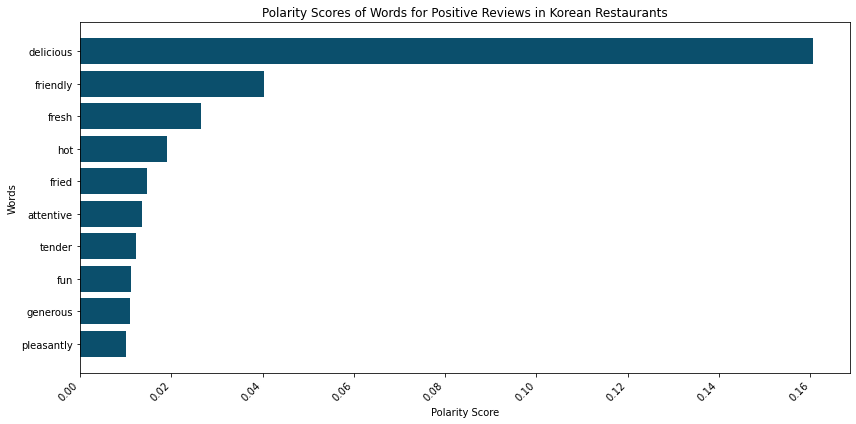

In [115]:
import matplotlib.pyplot as plt

# Extract the index (words) and polarity score
words = positive_top10.index
polarity_scores = positive_top10["polarity"]

words = words[::-1]
polarity_scores = polarity_scores[::-1]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(words, polarity_scores, color="#0B4F6C")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Set labels and title
plt.xlabel("Polarity Score")
plt.ylabel("Words")
plt.title("Polarity Scores of Words for Positive Reviews in Korean Restaurants")

# Show the plot
plt.tight_layout()
plt.show()

StatementMeta(sparkpvikeur, 33, 115, Finished, Available)

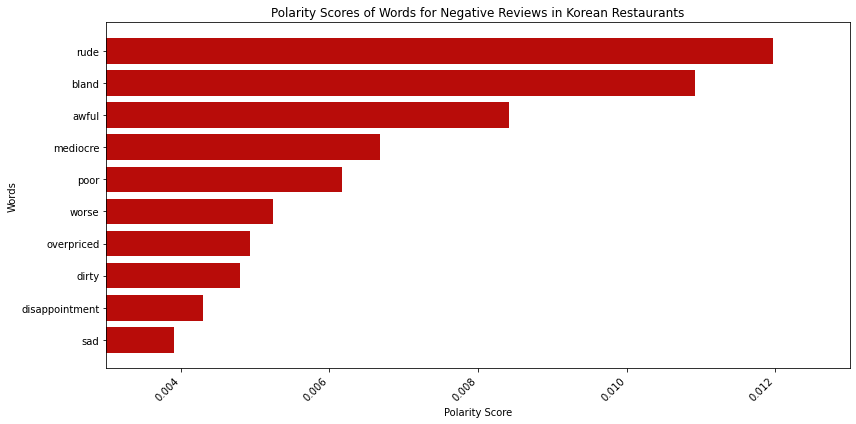

In [114]:
# Extract the index (words) and polarity score
words = negative_top10.index
polarity_scores = negative_top10["polarity"]

words = words[::-1]
polarity_scores = polarity_scores[::-1]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(words, polarity_scores * (-1), color="#B80C09")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Set labels and title
plt.xlabel("Polarity Score")
plt.ylabel("Words")
plt.title("Polarity Scores of Words for Negative Reviews in Korean Restaurants")
plt.xlim(0.003, 0.013)

# Show the plot
plt.tight_layout()
plt.savefig("red_plot.png")
plt.show()

In [128]:
from pyspark.sql.functions import col, split
from sklearn.feature_extraction.text import CountVectorizer


def get_polarity_score(dataset, review_type):
    dataset = dataset.withColumn("text", F.udf(filter_words)(F.col("text")))

    terms_train = dataset.select("text").rdd.flatMap(lambda row: row).collect()
    class_train = dataset.select("labels").rdd.flatMap(lambda row: row).collect()

    terms_test = dataset.select("text").rdd.flatMap(lambda row: row).collect()
    class_test = dataset.select("labels").rdd.flatMap(lambda row: row).collect()

    vectorizer = CountVectorizer()
    vectorizer_model = vectorizer.fit_transform(terms_train)

    svm = LinearSVC(max_iter=10000)
    svm.fit(vectorizer_model, class_train)

    coeff = svm.coef_[0]
    cuisine_words_score = pd.DataFrame(
        {"score": coeff, "word": vectorizer.get_feature_names()}
    )

    cuisine_reviews = pd.DataFrame(
        vectorizer_model.toarray(), columns=vectorizer.get_feature_names()
    )
    cuisine_reviews["labels"] = class_train

    if review_type == "positive":
        cuisine_frequency = cuisine_reviews[
            cuisine_reviews["labels"] == "positive"
        ].sum()[:-1]
    else:
        cuisine_frequency = cuisine_reviews[
            cuisine_reviews["labels"] == "negative"
        ].sum()[:-1]

    cuisine_words_score.set_index("word", inplace=True)
    cuisine_polarity_score = cuisine_words_score
    cuisine_polarity_score["frequency"] = cuisine_frequency

    cuisine_polarity_score["polarity"] = (
        cuisine_polarity_score.score
        * cuisine_polarity_score.frequency
        / cuisine_reviews.shape[0]
    )

    ## drop unnecessary words
    unuseful_positive_words = cuisine_polarity_score.loc[
        [
            "great",
            "amazing",
            "love",
            "best",
            "awesome",
            "excellent",
            "good",
            "favorite",
            "loved",
            "perfect",
            "gem",
            "perfectly",
            "wonderful",
            "happy",
            "enjoyed",
            "nice",
            "well",
            "super",
            "like",
            "better",
            "decent",
            "fine",
            "pretty",
            "enough",
            "excited",
            "impressed",
            "ready",
            "fantastic",
            "glad",
            "right",
            "fabulous",
        ]
    ]
    unuseful_negative_words = cuisine_polarity_score.loc[
        [
            "bad",
            "disappointed",
            "unfortunately",
            "disappointing",
            "horrible",
            "lacking",
            "terrible",
            "sorry",
            "disappoint",
            "worst",
        ]
    ]

    unuseful_words = unuseful_positive_words + unuseful_negative_words
    cuisine_polarity_score.drop(unuseful_words.index, axis=0, inplace=True)

    cuisine_polarity_score.polarity = cuisine_polarity_score.polarity.astype(float)
    cuisine_polarity_score.frequency = cuisine_polarity_score.frequency.astype(float)

    return cuisine_polarity_score

StatementMeta(sparkpvikeur, 33, 129, Finished, Available)

In [129]:
Japanese_reviews = get_dataset("Japanese")
Japanese_train, Japanese_test = Japanese_reviews.randomSplit([0.5, 0.5])

StatementMeta(sparkpvikeur, 33, 130, Finished, Available)

In [130]:
Japanese_polarity_score = get_polarity_score(Japanese_train, "positive")

StatementMeta(sparkpvikeur, 33, 131, Finished, Available)

In [143]:
Japanese_polarity_score = get_polarity_score(Japanese_train, "negative")

StatementMeta(sparkpvikeur, 33, 144, Finished, Available)

In [144]:
Japanese_dnm = Japanese_polarity_score[
    Japanese_polarity_score.polarity < 0
].sort_values("polarity")
Japanese_negative_top10 = Japanese_dnm[:10]

StatementMeta(sparkpvikeur, 33, 145, Finished, Available)

In [131]:
Japanese_dnm = Japanese_polarity_score[
    Japanese_polarity_score.polarity > 0
].sort_values("polarity", ascending=False)
Japanese_positive_top10 = Japanese_dnm[:10]

StatementMeta(sparkpvikeur, 33, 132, Finished, Available)

In [132]:
Japanese_positive_top10

StatementMeta(sparkpvikeur, 33, 133, Finished, Available)

,score,frequency,polarity
word,,,
delicious,0.630658,17750.0,0.129132
fresh,0.217987,17677.0,0.044451
friendly,0.186391,10722.0,0.023054
recommend,0.158203,9112.0,0.016629
incredible,0.629253,1403.0,0.010184
fun,0.296365,2978.0,0.010181
reasonable,0.349892,2399.0,0.009683
phenomenal,0.912085,864.0,0.009091
fast,0.210384,3568.0,0.008659


In [133]:
Japanese_dnm = Japanese_polarity_score[
    Japanese_polarity_score.polarity < 0
].sort_values("polarity")
Japanese_negative_top10 = Japanese_dnm[:10]

StatementMeta(sparkpvikeur, 33, 134, Finished, Available)

In [134]:
Japanese_negative_top10

StatementMeta(sparkpvikeur, 33, 135, Finished, Available)

,score,frequency,polarity
word,,,
won,-0.360497,1639.0,-0.006816
cold,-0.301390,1404.0,-0.004881
slow,-0.276158,1200.0,-0.003823
expensive,-0.236125,1396.0,-0.003802
bland,-0.674458,480.0,-0.003735
hard,-0.162388,1977.0,-0.003703
warm,-0.233779,1305.0,-0.003519
wrong,-0.197911,1369.0,-0.003125
mediocre,-0.882468,244.0,-0.002484


StatementMeta(sparkpvikeur, 33, 137, Finished, Available)

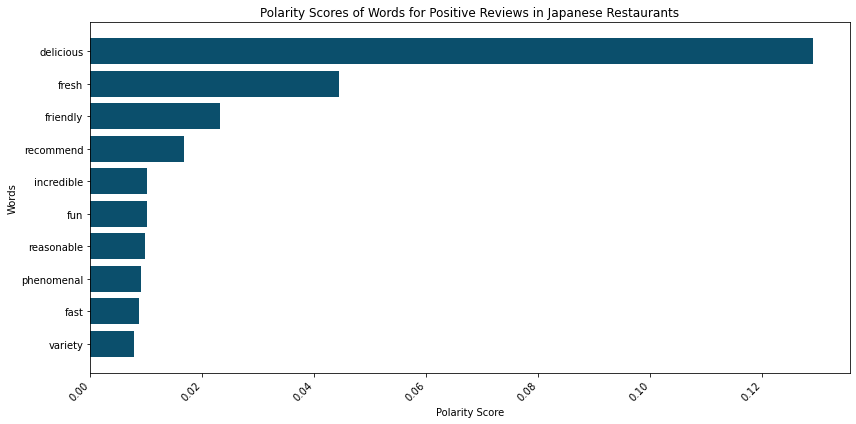

In [136]:
# Extract the index (words) and polarity score
words = Japanese_positive_top10.index
polarity_scores = Japanese_positive_top10["polarity"]

words = words[::-1]
polarity_scores = polarity_scores[::-1]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(words, polarity_scores, color="#0B4F6C")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Set labels and title
plt.xlabel("Polarity Score")
plt.ylabel("Words")
plt.title("Polarity Scores of Words for Positive Reviews in Japanese Restaurants")

# Show the plot
plt.tight_layout()
plt.show()

StatementMeta(sparkpvikeur, 33, 146, Finished, Available)

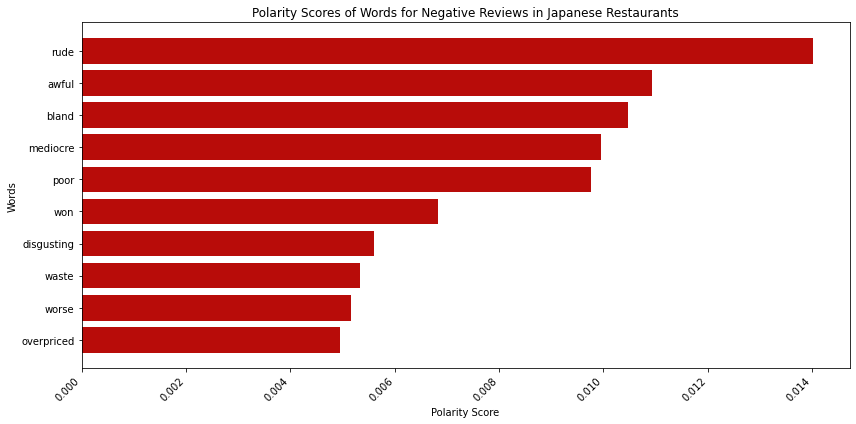

In [145]:
words = Japanese_negative_top10.index
polarity_scores = Japanese_negative_top10["polarity"]

words = words[::-1]
polarity_scores = polarity_scores[::-1]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(words, polarity_scores * (-1), color="#B80C09")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Set labels and title
plt.xlabel("Polarity Score")
plt.ylabel("Words")
plt.title("Polarity Scores of Words for Negative Reviews in Japanese Restaurants")
plt.xlim(0.003, 0.015)

# Show the plot
plt.tight_layout()
plt.show()

In [141]:
Thai_reviews = get_dataset("Thai")
Thai_train, Thai_test = Thai_reviews.randomSplit([0.5, 0.5])

Thai_polarity_score = get_polarity_score(Thai_train, "positive")

Thai_dnm = Thai_polarity_score[Thai_polarity_score.polarity > 0].sort_values(
    "polarity", ascending=False
)
Thai_positive_top10 = Thai_dnm[:10]

StatementMeta(sparkpvikeur, 33, 142, Finished, Available)

In [142]:
Thai_positive_top10

StatementMeta(sparkpvikeur, 33, 143, Finished, Available)

,score,frequency,polarity
word,,,
delicious,0.717085,8865.0,0.183045
friendly,0.341132,5069.0,0.049791
fresh,0.240278,5215.0,0.036081
recommend,0.198194,3698.0,0.021104
reasonable,0.496542,1134.0,0.016213
hot,0.143173,3860.0,0.015913
generous,0.652925,751.0,0.014119
incredible,0.751852,512.0,0.011084
attentive,0.264062,1369.0,0.010409


StatementMeta(sparkpvikeur, 33, 147, Finished, Available)

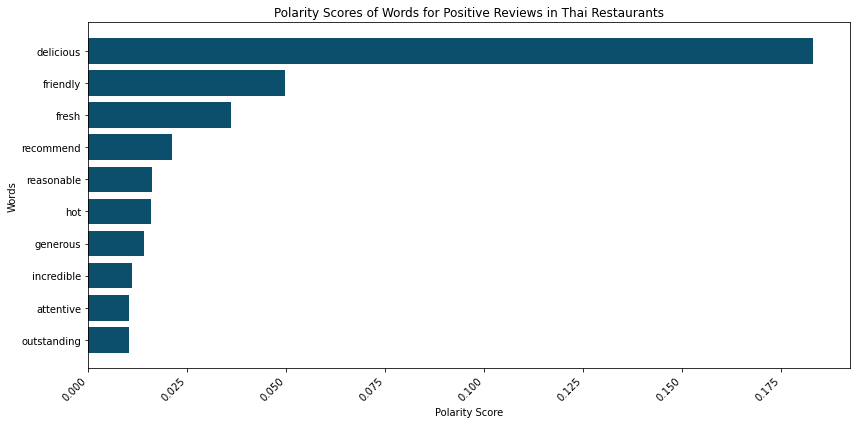

In [146]:
# Extract the index (words) and polarity score
words = Thai_positive_top10.index
polarity_scores = Thai_positive_top10["polarity"]

words = words[::-1]
polarity_scores = polarity_scores[::-1]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(words, polarity_scores, color="#0B4F6C")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Set labels and title
plt.xlabel("Polarity Score")
plt.ylabel("Words")
plt.title("Polarity Scores of Words for Positive Reviews in Thai Restaurants")

# Show the plot
plt.tight_layout()
plt.show()

In [147]:
Thai_polarity_score = get_polarity_score(Thai_train, "negative")

Thai_dnm = Thai_polarity_score[Thai_polarity_score.polarity < 0].sort_values("polarity")
Thai_negative_top10 = Thai_dnm[:10]

Thai_negative_top10

StatementMeta(sparkpvikeur, 33, 148, Finished, Available)

,score,frequency,polarity
word,,,
bland,-0.801745,697.0,-0.016091
mediocre,-1.171518,288.0,-0.009715
rude,-0.814762,403.0,-0.009455
awful,-0.778009,294.0,-0.006586
poor,-0.707433,274.0,-0.005581
waste,-0.951479,185.0,-0.005068
disgusting,-0.970191,145.0,-0.004051
cold,-0.385813,342.0,-0.003799
unacceptable,-2.243292,58.0,-0.003746


StatementMeta(sparkpvikeur, 33, 149, Finished, Available)

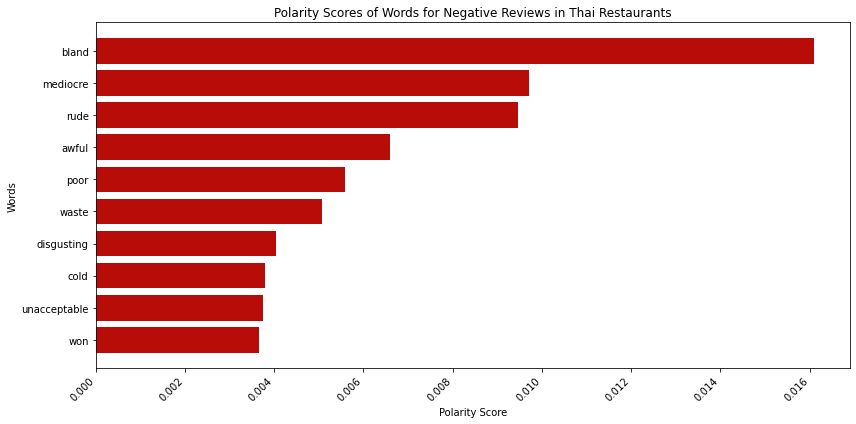

In [148]:
words = Thai_negative_top10.index
polarity_scores = Thai_negative_top10["polarity"]

words = words[::-1]
polarity_scores = polarity_scores[::-1]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(words, polarity_scores * (-1), color="#B80C09")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Set labels and title
plt.xlabel("Polarity Score")
plt.ylabel("Words")
plt.title("Polarity Scores of Words for Negative Reviews in Thai Restaurants")
# plt.xlim(0.00, 0.013)

# Show the plot
plt.tight_layout()
plt.show()

In [149]:
Chinese_reviews = get_dataset("Chinese")
Chinese_train, Chinese_test = Chinese_reviews.randomSplit([0.5, 0.5])

Chinese_polarity_score = get_polarity_score(Chinese_train, "positive")

Chinese_dnm = Chinese_polarity_score[Chinese_polarity_score.polarity > 0].sort_values(
    "polarity", ascending=False
)
Chinese_positive_top10 = Chinese_dnm[:10]

Chinese_positive_top10

StatementMeta(sparkpvikeur, 33, 150, Finished, Available)

,score,frequency,polarity
word,,,
delicious,0.627716,14603.0,0.114275
friendly,0.273740,8513.0,0.029051
fresh,0.219349,10235.0,0.027988
hot,0.130188,10314.0,0.016740
authentic,0.253108,4949.0,0.015616
recommend,0.164335,6882.0,0.014099
fast,0.232254,4793.0,0.013878
reasonable,0.405346,2133.0,0.010779
fun,0.243427,2741.0,0.008318


StatementMeta(sparkpvikeur, 33, 151, Finished, Available)

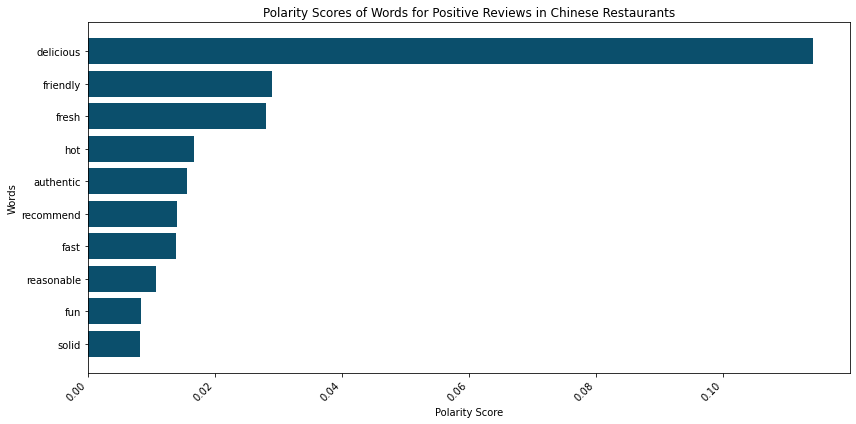

In [150]:
# Extract the index (words) and polarity score
words = Chinese_positive_top10.index
polarity_scores = Chinese_positive_top10["polarity"]

words = words[::-1]
polarity_scores = polarity_scores[::-1]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(words, polarity_scores, color="#0B4F6C")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Set labels and title
plt.xlabel("Polarity Score")
plt.ylabel("Words")
plt.title("Polarity Scores of Words for Positive Reviews in Chinese Restaurants")

# Show the plot
plt.tight_layout()
plt.show()

In [152]:
Chinese_polarity_score = get_polarity_score(Chinese_train, "negative")

Chinese_dnm = Chinese_polarity_score[Chinese_polarity_score.polarity < 0].sort_values(
    "polarity"
)
Chinese_negative_top10 = Chinese_dnm[:10]

Chinese_negative_top10

StatementMeta(sparkpvikeur, 33, 153, Finished, Available)

,score,frequency,polarity
word,,,
bland,-0.736475,1937.0,-0.017784
rude,-0.711342,1914.0,-0.016973
awful,-0.945411,1026.0,-0.012092
disgusting,-1.040535,911.0,-0.011817
mediocre,-0.918463,838.0,-0.009595
poor,-0.789878,946.0,-0.009315
cold,-0.376346,1786.0,-0.008379
refund,-1.097594,526.0,-0.007197
won,-0.295939,1840.0,-0.006788


StatementMeta(sparkpvikeur, 33, 154, Finished, Available)

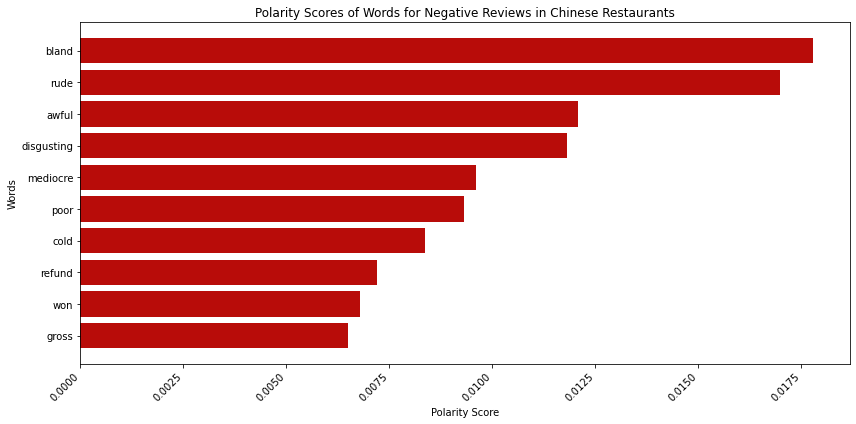

In [153]:
words = Chinese_negative_top10.index
polarity_scores = Chinese_negative_top10["polarity"]

words = words[::-1]
polarity_scores = polarity_scores[::-1]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(words, polarity_scores * (-1), color="#B80C09")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Set labels and title
plt.xlabel("Polarity Score")
plt.ylabel("Words")
plt.title("Polarity Scores of Words for Negative Reviews in Chinese Restaurants")
plt.xlim(0.0050, 0.018)

# Show the plot
plt.tight_layout()
plt.show()

In [154]:
Vietnamese_reviews = get_dataset("Vietnamese")
Vietnamese_train, Vietnamese_test = Vietnamese_reviews.randomSplit([0.5, 0.5])

Vietnamese_polarity_score = get_polarity_score(Vietnamese_train, "positive")

Vietnamese_dnm = Vietnamese_polarity_score[
    Vietnamese_polarity_score.polarity > 0
].sort_values("polarity", ascending=False)
Vietnamese_positive_top10 = Vietnamese_dnm[:10]

Vietnamese_positive_top10

StatementMeta(sparkpvikeur, 33, 155, Finished, Available)

,score,frequency,polarity
word,,,
delicious,0.624095,7521.0,0.157749
fresh,0.211654,5973.0,0.042487
friendly,0.266902,4325.0,0.038795
fast,0.338089,1736.0,0.019725
affordable,1.297649,441.0,0.019233
tender,0.547594,782.0,0.014391
reasonable,0.417511,949.0,0.013316
recommend,0.136030,2866.0,0.013102
rich,0.738488,472.0,0.011715


StatementMeta(sparkpvikeur, 33, 156, Finished, Available)

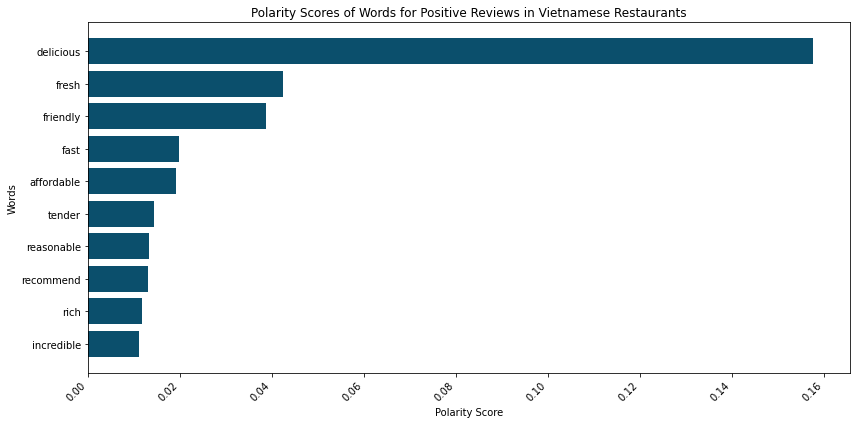

In [155]:
# Extract the index (words) and polarity score
words = Vietnamese_positive_top10.index
polarity_scores = Vietnamese_positive_top10["polarity"]

words = words[::-1]
polarity_scores = polarity_scores[::-1]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(words, polarity_scores, color="#0B4F6C")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Set labels and title
plt.xlabel("Polarity Score")
plt.ylabel("Words")
plt.title("Polarity Scores of Words for Positive Reviews in Vietnamese Restaurants")

# Show the plot
plt.tight_layout()
plt.show()

In [156]:
Vietnamese_polarity_score = get_polarity_score(Vietnamese_train, "negative")

Vietnamese_dnm = Vietnamese_polarity_score[
    Vietnamese_polarity_score.polarity < 0
].sort_values("polarity")
Vietnamese_negative_top10 = Vietnamese_dnm[:10]

Vietnamese_negative_top10

StatementMeta(sparkpvikeur, 33, 157, Finished, Available)

,score,frequency,polarity
word,,,
bland,-0.909860,521.0,-0.015931
rude,-0.898965,398.0,-0.012024
mediocre,-1.001408,195.0,-0.006563
poor,-0.779064,216.0,-0.005655
awful,-0.821718,180.0,-0.004971
won,-0.379819,377.0,-0.004812
disgusting,-1.093164,129.0,-0.004739
dirty,-0.656986,208.0,-0.004593
waste,-0.977121,136.0,-0.004466


StatementMeta(sparkpvikeur, 33, 158, Finished, Available)

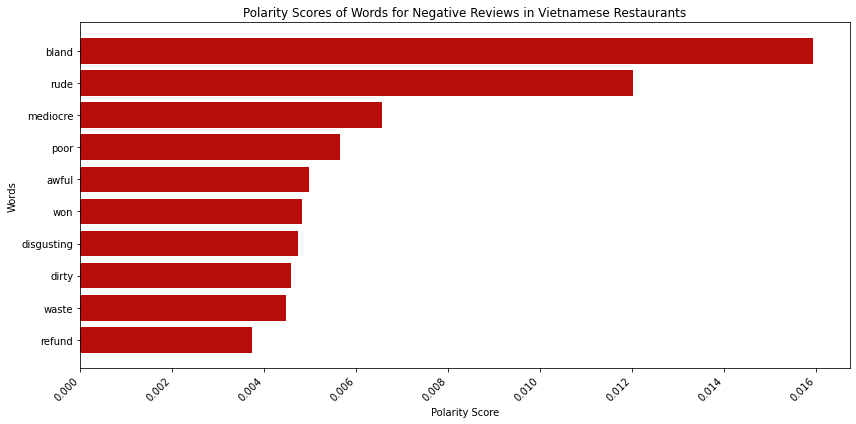

In [157]:
words = Vietnamese_negative_top10.index
polarity_scores = Vietnamese_negative_top10["polarity"]

words = words[::-1]
polarity_scores = polarity_scores[::-1]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(words, polarity_scores * (-1), color="#B80C09")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Set labels and title
plt.xlabel("Polarity Score")
plt.ylabel("Words")
plt.title("Polarity Scores of Words for Negative Reviews in Vietnamese Restaurants")
plt.xlim(0.002, 0.016)

# Show the plot
plt.tight_layout()
plt.show()

In [158]:
French_reviews = get_dataset("French")
French_train, French_test = French_reviews.randomSplit([0.5, 0.5])

French_polarity_score = get_polarity_score(French_train, "positive")

French_dnm = French_polarity_score[French_polarity_score.polarity > 0].sort_values(
    "polarity", ascending=False
)
French_positive_top10 = French_dnm[:10]

French_positive_top10

StatementMeta(sparkpvikeur, 33, 159, Finished, Available)

,score,frequency,polarity
word,,,
delicious,0.519593,10371.0,0.147704
die,0.923148,879.0,0.022242
friendly,0.179614,4147.0,0.020417
incredible,0.468560,1291.0,0.016581
fresh,0.155101,3785.0,0.016091
perfection,0.568103,1018.0,0.015852
recommend,0.130516,3946.0,0.014117
delightful,0.680756,689.0,0.012856
heaven,1.090333,429.0,0.012821


StatementMeta(sparkpvikeur, 33, 160, Finished, Available)

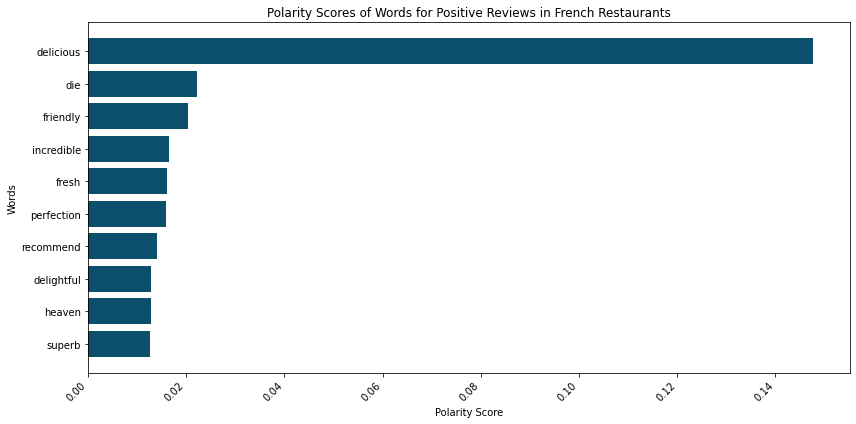

In [159]:
# Extract the index (words) and polarity score
words = French_positive_top10.index
polarity_scores = French_positive_top10["polarity"]

words = words[::-1]
polarity_scores = polarity_scores[::-1]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(words, polarity_scores, color="#0B4F6C")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Set labels and title
plt.xlabel("Polarity Score")
plt.ylabel("Words")
plt.title("Polarity Scores of Words for Positive Reviews in French Restaurants")

# Show the plot
plt.tight_layout()
plt.show()

In [160]:
French_polarity_score = get_polarity_score(French_train, "negative")

French_dnm = French_polarity_score[French_polarity_score.polarity < 0].sort_values(
    "polarity"
)
French_negative_top10 = French_dnm[:10]

French_negative_top10

StatementMeta(sparkpvikeur, 33, 161, Finished, Available)

,score,frequency,polarity
word,,,
rude,-0.854016,634.0,-0.014841
mediocre,-1.102159,425.0,-0.012839
awful,-1.240246,320.0,-0.010878
poor,-0.932538,424.0,-0.010838
cold,-0.499318,777.0,-0.010634
bland,-0.679282,473.0,-0.008807
overpriced,-0.730252,343.0,-0.006866
disappointment,-0.842512,284.0,-0.006558
waste,-0.817233,228.0,-0.005107


StatementMeta(sparkpvikeur, 33, 162, Finished, Available)

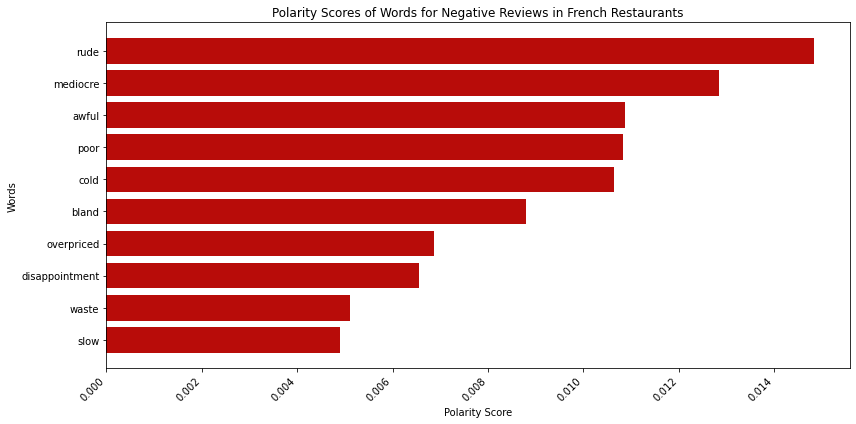

In [161]:
words = French_negative_top10.index
polarity_scores = French_negative_top10["polarity"]

words = words[::-1]
polarity_scores = polarity_scores[::-1]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(words, polarity_scores * (-1), color="#B80C09")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Set labels and title
plt.xlabel("Polarity Score")
plt.ylabel("Words")
plt.title("Polarity Scores of Words for Negative Reviews in French Restaurants")
plt.xlim(0.003, 0.015)

# Show the plot
plt.tight_layout()
plt.show()

In [162]:
Italian_reviews = get_dataset("Italian")
Italian_train, Italian_test = Italian_reviews.randomSplit([0.5, 0.5])

Italian_polarity_score = get_polarity_score(Italian_train, "positive")

Italian_dnm = Italian_polarity_score[Italian_polarity_score.polarity > 0].sort_values(
    "polarity", ascending=False
)
Italian_positive_top10 = Italian_dnm[:10]

Italian_positive_top10

StatementMeta(sparkpvikeur, 33, 163, Finished, Available)

,score,frequency,polarity
word,,,
delicious,0.563559,42755.0,0.125925
friendly,0.263824,23246.0,0.032052
fresh,0.208104,23625.0,0.025694
recommend,0.169390,17514.0,0.015505
incredible,0.551996,4341.0,0.012523
outstanding,0.465147,4892.0,0.011892
die,0.508333,3323.0,0.008828
perfection,0.557264,3025.0,0.008810
reasonable,0.322967,4562.0,0.007700


StatementMeta(sparkpvikeur, 33, 164, Finished, Available)

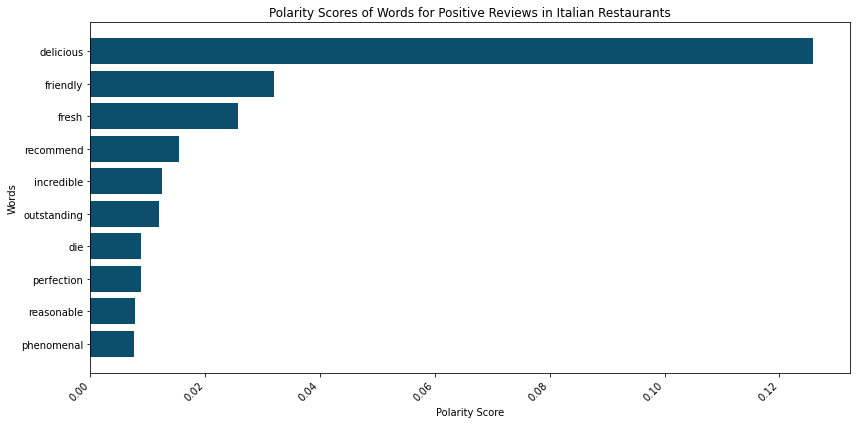

In [163]:
# Extract the index (words) and polarity score
words = Italian_positive_top10.index
polarity_scores = Italian_positive_top10["polarity"]

words = words[::-1]
polarity_scores = polarity_scores[::-1]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(words, polarity_scores, color="#0B4F6C")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Set labels and title
plt.xlabel("Polarity Score")
plt.ylabel("Words")
plt.title("Polarity Scores of Words for Positive Reviews in Italian Restaurants")

# Show the plot
plt.tight_layout()
plt.show()

In [164]:
Italian_polarity_score = get_polarity_score(Italian_train, "negative")

Italian_dnm = Italian_polarity_score[Italian_polarity_score.polarity < 0].sort_values(
    "polarity"
)
Italian_negative_top10 = Italian_dnm[:10]

Italian_negative_top10

StatementMeta(sparkpvikeur, 33, 165, Finished, Available)

,score,frequency,polarity
word,,,
bland,-0.811017,3477.0,-0.014737
rude,-0.642542,4077.0,-0.013691
cold,-0.438996,5193.0,-0.011914
mediocre,-0.927451,2206.0,-0.010693
awful,-0.802959,2407.0,-0.010101
poor,-0.679134,2727.0,-0.009679
won,-0.335935,3886.0,-0.006822
overpriced,-0.672999,1661.0,-0.005842
waste,-0.695442,1476.0,-0.005365


StatementMeta(sparkpvikeur, 33, 166, Finished, Available)

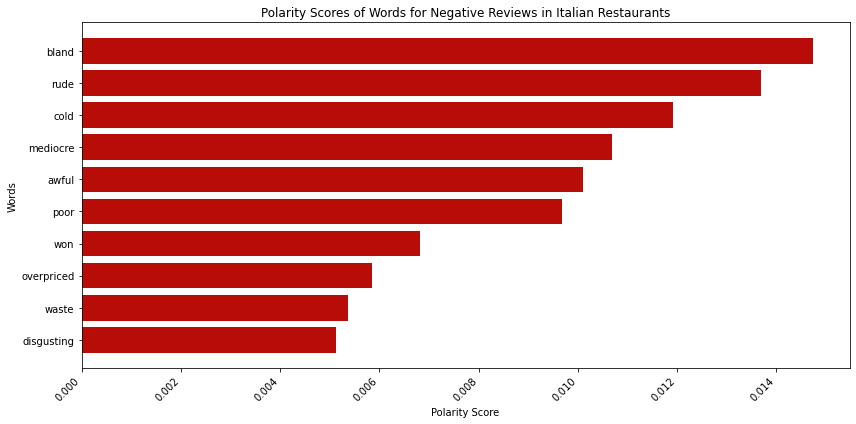

In [165]:
words = Italian_negative_top10.index
polarity_scores = Italian_negative_top10["polarity"]

words = words[::-1]
polarity_scores = polarity_scores[::-1]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(words, polarity_scores * (-1), color="#B80C09")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Set labels and title
plt.xlabel("Polarity Score")
plt.ylabel("Words")
plt.title("Polarity Scores of Words for Negative Reviews in Italian Restaurants")
plt.xlim(0.003, 0.013)

# Show the plot
plt.tight_layout()
plt.show()